In [3]:
%pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [7]:
import torch
import multiprocessing


try:
    multiprocessing.set_start_method('spawn', force=True)
    print("Multiprocessing start method set to 'spawn'.")
except ValueError:

    print("Multiprocessing start method already set.")

Multiprocessing start method set to 'spawn'.


=== Optimized WikiText-2 Next Word Predictor ===
Initializing predictor...
Using GPU: Tesla T4
GPU Memory: 14.7 GB
Using device: cuda
Mixed precision: bf16
Loading WikiText-2 dataset...


Filter:   0%|          | 0/4358 [00:00<?, ? examples/s]

Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3760 [00:00<?, ? examples/s]

Tokenizing WikiText-2 dataset...


Tokenizing:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/5000 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset loaded successfully!
Train samples: 5000
Validation samples: 500
Test samples: 500
Sample text: Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III...

Starting fine-tuning with device-specific optimizations...
Starting fine-tuning on WikiText-2 with cuda optimizations...


Step,Training Loss,Validation Loss
500,3.627300,3.557544


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Fine-tuning completed in 6.66 minutes!
Model saved to ./wikitext2_fine_tuned_gpt2

=== Next Word Prediction Demo ===

Input: 'The history of artificial intelligence'
Top 5 predictions:
  1. ' is' (probability: 0.4339)
  2. ' has' (probability: 0.2124)
  3. ' ,' (probability: 0.1040)
  4. ' and' (probability: 0.0509)
  5. ' in' (probability: 0.0509)

Input: 'In the field of computer science'
Top 5 predictions:
  1. ' ,' (probability: 0.9579)
  2. ' and' (probability: 0.0132)
  3. ',' (probability: 0.0132)
  4. ' there' (probability: 0.0045)
  5. ' at' (probability: 0.0022)

Input: 'Machine learning algorithms are'
Top 5 predictions:
  1. ' based' (probability: 0.1070)
  2. ' used' (probability: 0.1070)
  3. ' a' (probability: 0.1070)
  4. ' often' (probability: 0.0524)
  5. ' not' (probability: 0.0524)

Input: 'The research shows that'
Top 5 predictions:
  1. ' the' (probability: 0.4868)
  2. ' a' (probability: 0.0571)
  3. ' when' (probability: 0.0280)
  4. ' it' (probability: 0.0137)


Calculating top-5 accuracy: 100%|██████████| 3/3 [00:40<00:00, 13.37s/it]



Evaluation Results:
Validation Perplexity: 32.3289
Test Perplexity: 36.7366
Validation Top-1 Accuracy: 0.3411
Test Top-1 Accuracy: 0.3031
Validation Top-5 Accuracy: 0.5281
Test Top-5 Accuracy: 0.5229


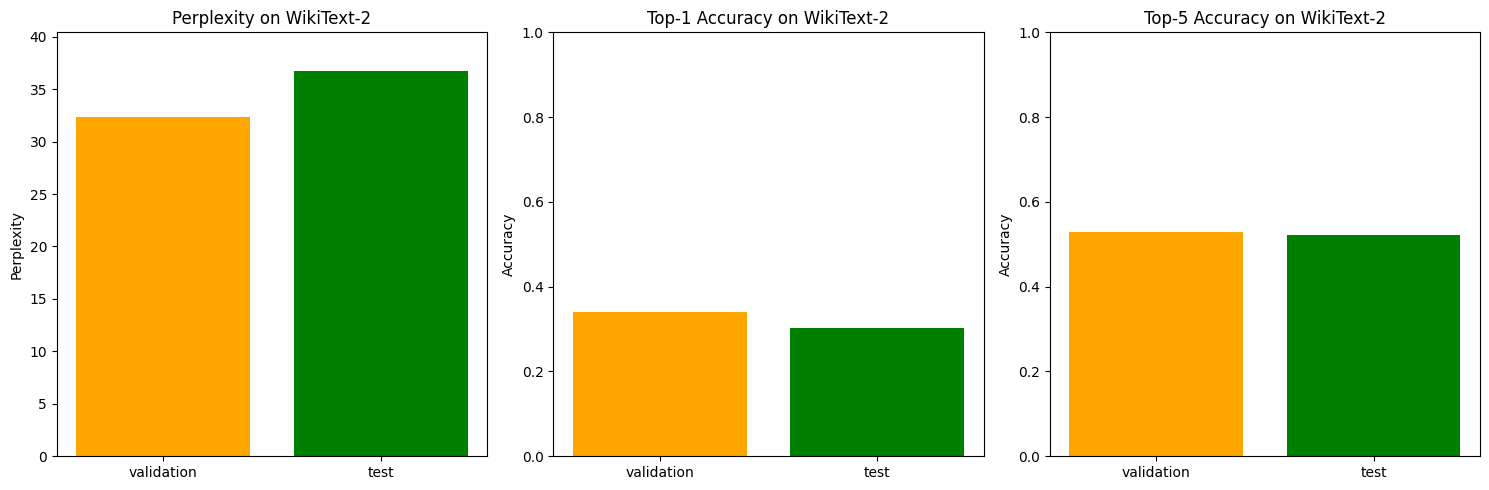

Model saved to ./optimized_wikitext2_model

=== Training Complete! ===
Training completed on cuda!


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import warnings
import os
import json
from typing import Dict, List, Tuple, Optional
import time
import gc

warnings.filterwarnings('ignore')

class OptimizedWikiText2NextWordPredictor:
    def __init__(self, model_name="gpt2", max_length=128, use_mixed_precision="auto"):

        self.model_name = model_name
        self.max_length = max_length
        self.wikitext_version = "wikitext-2-raw-v1"


        self.device, self.mixed_precision = self._setup_device_and_precision(use_mixed_precision)

        print(f"Using device: {self.device}")
        print(f"Mixed precision: {self.mixed_precision}")


        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = GPT2LMHeadModel.from_pretrained(model_name)


        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token


        self.model.gradient_checkpointing_enable()


        self.model.to(self.device)


        self._clear_cache()

    def _setup_device_and_precision(self, use_mixed_precision):

        if torch.cuda.is_available():
            device = torch.device('cuda')
            device_name = torch.cuda.get_device_name(0)
            memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
            print(f"Using GPU: {device_name}")
            print(f"GPU Memory: {memory_gb:.1f} GB")


            if use_mixed_precision == "auto":

                if torch.cuda.is_bf16_supported():
                    mixed_precision = "bf16"
                else:
                    mixed_precision = "fp16"
            else:
                mixed_precision = use_mixed_precision

        elif torch.backends.mps.is_available():
            device = torch.device('mps')
            print("Using Apple Silicon GPU (MPS)")

            mixed_precision = "no"
            if use_mixed_precision not in ["auto", "no"]:
                print("Warning: Mixed precision not supported on MPS, using fp32")

        else:
            device = torch.device('cpu')
            print("Using CPU")
            mixed_precision = "no"
            if use_mixed_precision not in ["auto", "no"]:
                print("Warning: Mixed precision not supported on CPU, using fp32")

        return device, mixed_precision

    def _clear_cache(self):

        if self.device.type == 'cuda':
            torch.cuda.empty_cache()
        elif self.device.type == 'mps':
            torch.mps.empty_cache()
        gc.collect()

    def optimize_memory(self):

        if self.device.type == 'cuda':

            torch.cuda.empty_cache()


            try:
                torch.cuda.set_per_process_memory_fraction(0.9)
            except:
                pass

        elif self.device.type == 'mps':

            torch.mps.empty_cache()


        if hasattr(self.model.config, 'use_memory_efficient_attention'):
            self.model.config.use_memory_efficient_attention = True

    def load_wikitext2_data(self, use_streaming=False, max_samples=None):

        print("Loading WikiText-2 dataset...")


        if use_streaming:
            dataset = load_dataset("wikitext", "wikitext-2-raw-v1", streaming=True)
        else:
            dataset = load_dataset("wikitext", "wikitext-2-raw-v1")


        def filter_text(example):
            text = example['text'].strip()
            return len(text) > 20 and not text.startswith('=') and not text.startswith('==')

        dataset = dataset.filter(filter_text)


        if max_samples and not use_streaming:
            dataset['train'] = dataset['train'].select(range(min(max_samples, len(dataset['train']))))
            dataset['validation'] = dataset['validation'].select(range(min(max_samples//10, len(dataset['validation']))))
            dataset['test'] = dataset['test'].select(range(min(max_samples//10, len(dataset['test']))))

        def tokenize_function(examples):
            texts = [text.strip() for text in examples['text'] if len(text.strip()) > 20]

            if not texts:
                return {"input_ids": [], "attention_mask": [], "labels": []}


            tokenized = self.tokenizer(
                texts,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors=None,
                add_special_tokens=True
            )


            tokenized["labels"] = tokenized["input_ids"].copy()

            return tokenized


        print("Tokenizing WikiText-2 dataset...")


        num_proc = 1

        tokenized_dataset = dataset.map(
            tokenize_function,
            batched=True,
            batch_size=1000,
            remove_columns=dataset["train"].column_names,
            desc="Tokenizing",
            num_proc=num_proc
        )


        tokenized_dataset = tokenized_dataset.filter(
            lambda x: len(x["input_ids"]) > 10
        )

        self.train_dataset = tokenized_dataset["train"]
        self.val_dataset = tokenized_dataset["validation"]
        self.test_dataset = tokenized_dataset["test"]

        print(f"Dataset loaded successfully!")
        print(f"Train samples: {len(self.train_dataset)}")
        print(f"Validation samples: {len(self.val_dataset)}")
        print(f"Test samples: {len(self.test_dataset)}")


        if len(self.train_dataset) > 0:
            sample = self.train_dataset[0]
            decoded_text = self.tokenizer.decode(sample['input_ids'][:50], skip_special_tokens=True)
            print(f"Sample text: {decoded_text}...")

    def fine_tune_on_wikitext2(self,
                               output_dir="./wikitext2_fine_tuned_gpt2",
                               epochs=2,
                               batch_size=8,
                               learning_rate=2e-5,
                               warmup_steps=100,
                               save_steps=500,
                               eval_steps=500,
                               logging_steps=50):

        print(f"Starting fine-tuning on WikiText-2 with {self.device} optimizations...")

        self.optimize_memory()


        if self.device.type == 'mps':
            batch_size = min(batch_size, 4)
            print(f"Adjusted batch size to {batch_size} for MPS")


        training_args = TrainingArguments(
            output_dir=output_dir,
            overwrite_output_dir=True,
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            gradient_accumulation_steps=2,


            learning_rate=learning_rate,
            weight_decay=0.01,
            adam_epsilon=1e-8,
            max_grad_norm=1.0,


            lr_scheduler_type="cosine",
            warmup_steps=warmup_steps,


            eval_strategy="steps",
            eval_steps=eval_steps,
            save_steps=save_steps,
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,


            logging_steps=logging_steps,
            logging_strategy="steps",


            dataloader_pin_memory=(self.device.type == 'cuda'),
            remove_unused_columns=False,
            prediction_loss_only=True,


            fp16=(self.mixed_precision == "fp16"),
            bf16=(self.mixed_precision == "bf16"),
            dataloader_num_workers=1 if self.device.type == 'mps' else 2,


            report_to=None,


            gradient_checkpointing=True,
        )


        data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer,
            mlm=False,
            return_tensors="pt",
        )


        trainer = Trainer(
            model=self.model,
            args=training_args,
            data_collator=data_collator,
            train_dataset=self.train_dataset,
            eval_dataset=self.val_dataset,
        )


        start_time = time.time()

        try:

            trainer.train()


            trainer.save_model()
            self.tokenizer.save_pretrained(output_dir)

            training_time = time.time() - start_time
            print(f"Fine-tuning completed in {training_time/60:.2f} minutes!")
            print(f"Model saved to {output_dir}")


            del trainer
            self._clear_cache()

        except Exception as e:
            print(f"Training failed with error: {e}")

            self._clear_cache()
            raise

    def calculate_perplexity_fast(self, dataset, batch_size=16, max_samples=1000):

        self.model.eval()


        if self.device.type == 'mps':
            batch_size = min(batch_size, 8)


        if max_samples and len(dataset) > max_samples:
            dataset = dataset.select(range(max_samples))


        data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer,
            mlm=False,
        )

        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=data_collator,
            pin_memory=(self.device.type == 'cuda')
        )

        total_loss = 0
        num_batches = 0

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Calculating perplexity"):
                input_ids = batch['input_ids'].to(self.device, non_blocking=True)
                attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
                labels = batch['labels'].to(self.device, non_blocking=True)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_loss += loss.item()
                num_batches += 1

        avg_loss = total_loss / num_batches
        perplexity = torch.exp(torch.tensor(avg_loss))

        return perplexity.item()

    def calculate_top_k_accuracy_fast(self, dataset, k=5, batch_size=16, max_samples=1000):

        self.model.eval()


        if self.device.type == 'mps':
            batch_size = min(batch_size, 4)


        if max_samples and len(dataset) > max_samples:
            dataset = dataset.select(range(max_samples))

        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for i in tqdm(range(0, len(dataset), batch_size), desc=f"Calculating top-{k} accuracy"):
                batch_end = min(i + batch_size, len(dataset))
                batch_data = dataset[i:batch_end]


                if isinstance(batch_data['input_ids'], list):
                    input_ids = torch.stack([torch.tensor(seq) for seq in batch_data['input_ids']])
                else:
                    input_ids = batch_data['input_ids']

                input_ids = input_ids.to(self.device, non_blocking=True)


                for seq_idx in range(input_ids.size(0)):
                    sequence = input_ids[seq_idx]


                    if len(sequence) < 10:
                        continue


                    sequence = sequence[:50]


                    for pos in range(1, len(sequence) - 1):
                        input_seq = sequence[:pos].unsqueeze(0)
                        target_token = sequence[pos].item()

                        outputs = self.model(input_seq)
                        logits = outputs.logits[0, -1, :]


                        top_k_tokens = torch.topk(logits, k, dim=-1).indices


                        if target_token in top_k_tokens:
                            correct_predictions += 1
                        total_predictions += 1

        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        return accuracy

    def predict_next_word(self, text, num_predictions=5, temperature=0.7):

        self.model.eval()


        inputs = self.tokenizer.encode(text, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model(inputs)
            predictions = outputs.logits[0, -1, :]


            predictions = predictions / temperature


            probabilities = torch.softmax(predictions, dim=-1)

            top_predictions = torch.topk(probabilities, num_predictions)

            results = []
            for i in range(num_predictions):
                token_id = top_predictions.indices[i].item()
                probability = top_predictions.values[i].item()
                word = self.tokenizer.decode([token_id])
                results.append((word, probability))

            return results

    def generate_text(self, prompt, max_length=100, temperature=0.7, do_sample=True):

        self.model.eval()

        inputs = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model.generate(
                inputs,
                max_length=max_length,
                temperature=temperature,
                do_sample=do_sample,
                pad_token_id=self.tokenizer.eos_token_id,
                num_return_sequences=1,
                no_repeat_ngram_size=2,
                top_k=50,
                top_p=0.95
            )

            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            return generated_text

    def evaluate_fast(self, sample_size=500):

        print("Running fast evaluation on WikiText-2...")

        if self.device.type == 'mps':
            sample_size = min(sample_size, 200)

        val_subset = self.val_dataset.select(range(min(sample_size, len(self.val_dataset))))
        test_subset = self.test_dataset.select(range(min(sample_size, len(self.test_dataset))))

        val_perplexity = self.calculate_perplexity_fast(val_subset, batch_size=16, max_samples=sample_size)
        test_perplexity = self.calculate_perplexity_fast(test_subset, batch_size=16, max_samples=sample_size)

        accuracy_sample_size = min(100, sample_size // 5)
        val_top1_acc = self.calculate_top_k_accuracy_fast(val_subset, k=1, max_samples=accuracy_sample_size)
        val_top5_acc = self.calculate_top_k_accuracy_fast(val_subset, k=5, max_samples=accuracy_sample_size)

        test_top1_acc = self.calculate_top_k_accuracy_fast(test_subset, k=1, max_samples=accuracy_sample_size)
        test_top5_acc = self.calculate_top_k_accuracy_fast(test_subset, k=5, max_samples=accuracy_sample_size)

        results = {
            'perplexity': {
                'validation': val_perplexity,
                'test': test_perplexity
            },
            'top1_accuracy': {
                'validation': val_top1_acc,
                'test': test_top1_acc
            },
            'top5_accuracy': {
                'validation': val_top5_acc,
                'test': test_top5_acc
            }
        }

        return results

    def plot_results(self, results):

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        datasets = ['validation', 'test']
        perplexities = [results['perplexity'][d] for d in datasets]

        axes[0].bar(datasets, perplexities, color=['orange', 'green'])
        axes[0].set_title('Perplexity on WikiText-2')
        axes[0].set_ylabel('Perplexity')
        axes[0].set_ylim(0, max(perplexities) * 1.1)

        top1_accs = [results['top1_accuracy'][d] for d in datasets]
        axes[1].bar(datasets, top1_accs, color=['orange', 'green'])
        axes[1].set_title('Top-1 Accuracy on WikiText-2')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_ylim(0, 1)

        top5_accs = [results['top5_accuracy'][d] for d in datasets]
        axes[2].bar(datasets, top5_accs, color=['orange', 'green'])
        axes[2].set_title('Top-5 Accuracy on WikiText-2')
        axes[2].set_ylabel('Accuracy')
        axes[2].set_ylim(0, 1)

        plt.tight_layout()
        plt.show()

    def save_model(self, output_dir):

        os.makedirs(output_dir, exist_ok=True)
        self.model.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        print(f"Model saved to {output_dir}")

    def load_model(self, model_dir):

        self.model = GPT2LMHeadModel.from_pretrained(model_dir)
        self.tokenizer = AutoTokenizer.from_pretrained(model_dir)
        self.model.to(self.device)
        print(f"Model loaded from {model_dir}")

def main():

    print("=== Optimized WikiText-2 Next Word Predictor ===")
    print("Initializing predictor...")

    predictor = OptimizedWikiText2NextWordPredictor(
        model_name="gpt2",
        max_length=128,
        use_mixed_precision="auto"
    )

    predictor.load_wikitext2_data(
        use_streaming=False,
        max_samples=5000
    )

    print("\nStarting fine-tuning with device-specific optimizations...")
    predictor.fine_tune_on_wikitext2(
        epochs=1,
        batch_size=4,
        learning_rate=2e-5,
        warmup_steps=50,
        save_steps=500,
        eval_steps=500,
        logging_steps=50
    )

    print("\n=== Next Word Prediction Demo ===")
    test_sentences = [
        "The history of artificial intelligence",
        "In the field of computer science",
        "Machine learning algorithms are",
        "The research shows that",
        "According to the study"
    ]

    for sentence in test_sentences:
        predictions = predictor.predict_next_word(sentence, num_predictions=5)
        print(f"\nInput: '{sentence}'")
        print("Top 5 predictions:")
        for i, (word, prob) in enumerate(predictions, 1):
            print(f"  {i}. '{word}' (probability: {prob:.4f})")

    print("\n=== Text Generation Demo ===")
    prompts = [
        "The concept of machine learning",
        "In computer science, algorithms",
        "The development of artificial intelligence",
        "Research in natural language processing"
    ]

    for prompt in prompts:
        generated = predictor.generate_text(prompt, max_length=80)
        print(f"\nPrompt: '{prompt}'")
        print(f"Generated: '{generated}'")

    print("\n=== Fast Model Evaluation on WikiText-2 ===")
    print("Running fast evaluation...")

    results = predictor.evaluate_fast(sample_size=200)

    print("\nEvaluation Results:")
    print(f"Validation Perplexity: {results['perplexity']['validation']:.4f}")
    print(f"Test Perplexity: {results['perplexity']['test']:.4f}")
    print(f"Validation Top-1 Accuracy: {results['top1_accuracy']['validation']:.4f}")
    print(f"Test Top-1 Accuracy: {results['top1_accuracy']['test']:.4f}")
    print(f"Validation Top-5 Accuracy: {results['top5_accuracy']['validation']:.4f}")
    print(f"Test Top-5 Accuracy: {results['top5_accuracy']['test']:.4f}")

    try:
        predictor.plot_results(results)
    except Exception as e:
        print(f"Plotting failed: {e}")

    predictor.save_model("./optimized_wikitext2_model")

    print(f"\n=== Training Complete! ===")
    print(f"Training completed on {predictor.device}!")

if __name__ == "__main__":
    main()